# 🔵 Inputs

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import subprocess
from sklearn.preprocessing import MinMaxScaler
from IPython.display import SVG
from scipy.optimize import curve_fit

results = "results.csv"
cleaned_results = "cleaned_results.csv"


plt.rcParams['text.usetex'] = True
sns.set()

In [2]:
# Real Function
def func(x):
    a=10
    b=-0.5
    c=-0.5
    d=2
    return a*np.exp(b*np.exp(c*x + d))

def plt_svg(svg_path):
    subprocess.run(["convert", svg_path + ".svg", svg_path + ".png"], shell=True)
    return plt.imread(svg_path + ".png")

def least_squares_fit(function, X, y, guess, method=None):
    params, covariance = curve_fit(function, X, y, guess, method=method, maxfev=1000000)
    return params

def least_squares(X, y_real, func, *params):
    if params:
        y_pred = func(X, *params)
    else:
        y_pred = func(X)
    return np.sum( (y_real - y_pred)**2)/len(y_real)

## 🔷 O Problema
O fitness score é calculado como o erro médio quadrático.
- Nesse caso não temos erro

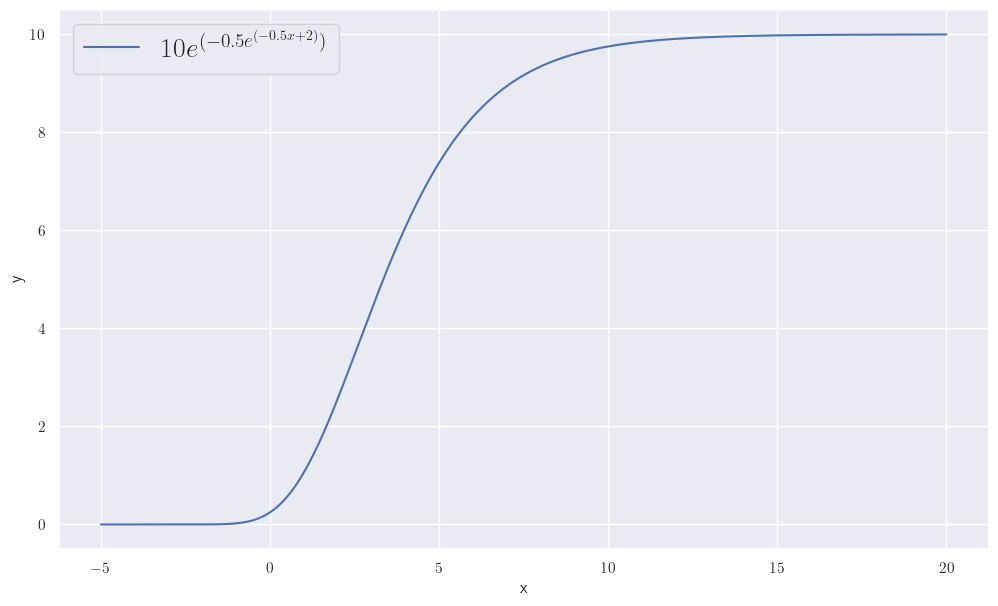

In [3]:
plt.figure(figsize=(12,7))
X = np.linspace(-5, 20, 1000)
y = func(X)
sns.lineplot(x=X, y=y, label="$10e^{(-0.5e^{(-0.5x+2)})}$")
plt.ylabel("y"); plt.xlabel("x")
plt.legend(fontsize=20)
plt.show()

# Adjusting Data

In [4]:
dirs = ["output", "output_const_range", "output_generations", "output_inten_scaled", "output_intensified", "output_scaled",
       "output_expr_size/test1", "output_expr_size/test2", "output_expr_size/test3"]

for d in dirs:
    data = pd.read_csv(d + "/" + results)
    colum = []
    for col in data.columns:
        colum.append(col.strip())
    data.columns = colum
    # data.training_time = data.training_time/60
    data.to_csv(d + "/" + cleaned_results, index=False)

# 🔵 1. Output
Caso base. Equação
$$10*\exp(-0.5*exp(-0.5*x + 2))$$
- 🔴 X range: (0, 15)

- Max generations = 3
- max_expression_size: 3
- max_island_count: population/10

- 🔴 Not Normalized
- 🔴 Constants range from 0 to 1

In [5]:
path = "output/"

data = pd.read_csv(path + cleaned_results)

## Fitness X Population Size

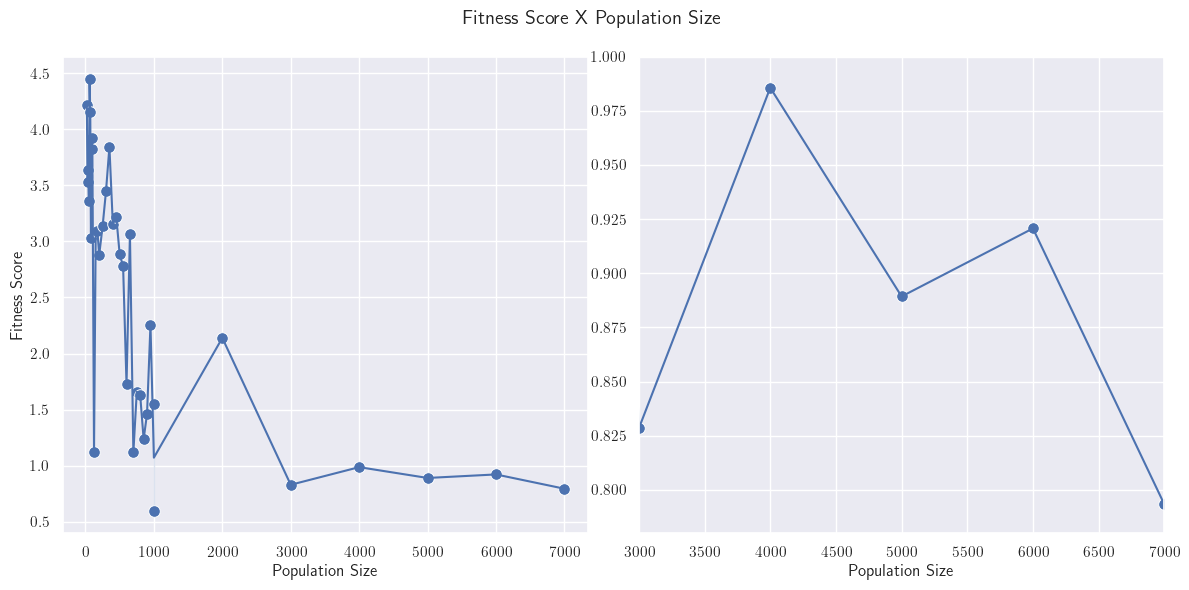

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
plt.suptitle("Fitness Score X Population Size")


sns.lineplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0]) 
sns.scatterplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0], s=70)
plt.tight_layout()

for ax in axs:
    ax.set_xlabel("Population Size")
    ax.set_ylabel("Fitness Score")
    
axs[1].set_xlim((3000, 7000))
axs[1].set_ylim((0.78, 1))
axs[1].set_ylabel(" ", visible=False)


sns.lineplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1])
sns.scatterplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1], s=70)
plt.show()

## Training Time X Population Size

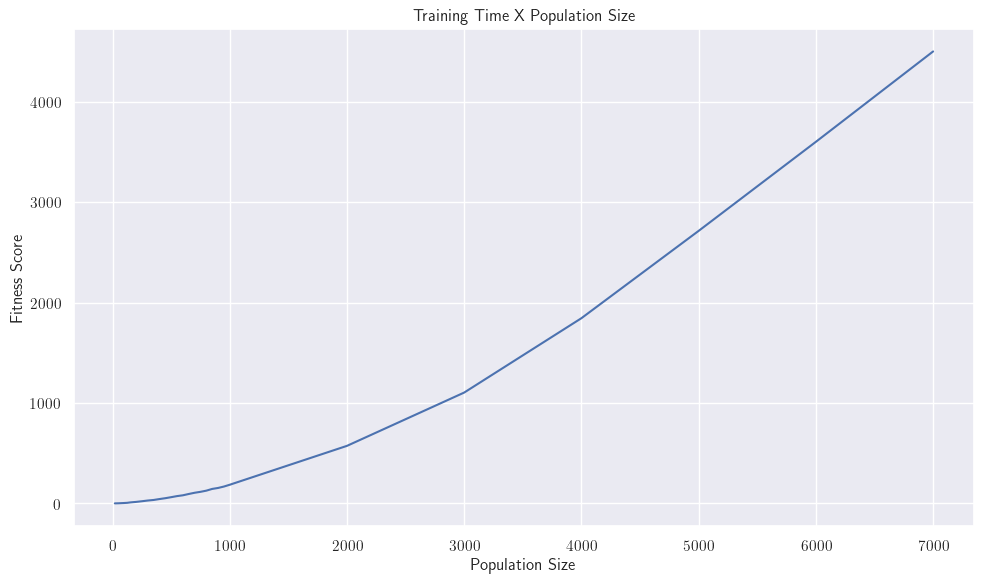

In [7]:
plt.figure(figsize=(10, 6))
plt.title("Training Time X Population Size ")

sns.lineplot(data, x=data.population_size, y=data["training_time"]) 
plt.tight_layout()

plt.xlabel("Population Size")
plt.ylabel("Fitness Score")

plt.show()

## Best Fit

In [8]:
best_tree = data.sort_values("fitness_score", axis=0)
best_tree = best_tree.reset_index(drop=True)
best_index = str(best_tree.population_size[0])

img_path = path + "trees/tree-" + best_index

best_data = pd.read_csv(path + f"data/data-{best_index}.csv")

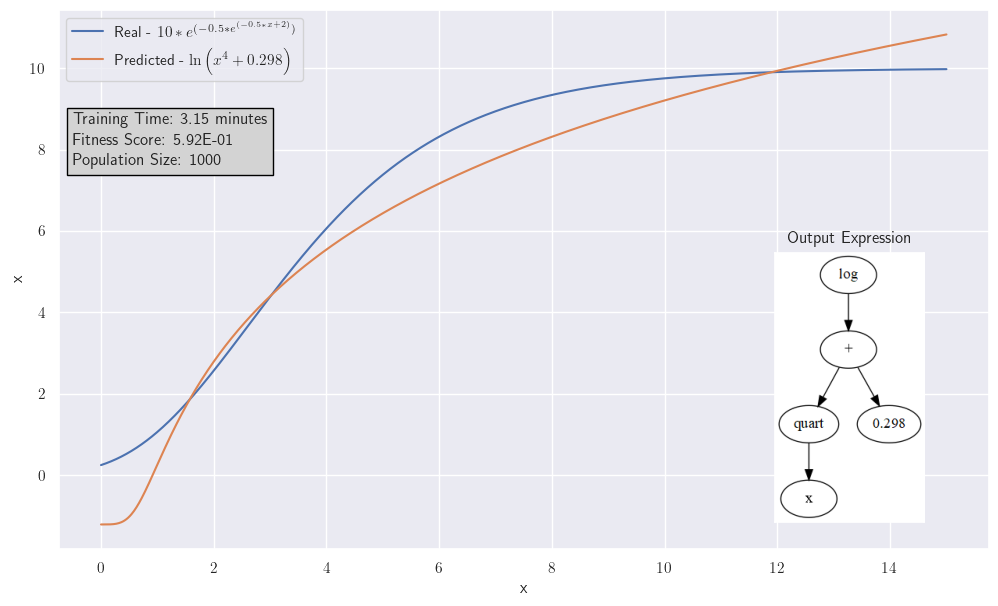

In [9]:
# fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

plt.figure(figsize=(12, 7))
plt.tight_layout()

sns.lineplot(x=best_data.x, y=func(best_data.x), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$")
sns.lineplot(x=best_data.x, y=best_data.y, label=r"Predicted - $\ln\Big(x^4 + 0.298\Big)$")

plt.annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Fitness Score: {best_tree.fitness_score[0]:.2E}
Population Size: {best_index}""", 
            (-0.5, 7.6), bbox={"facecolor": "lightgray", "edgecolor": "black"},
            linespacing = 1.5)

img = plt_svg(img_path)
ins = plt.gca().inset_axes([0.6, 0.05, 0.5, 0.5])
ins.imshow(img)
ins.get_xaxis().set_visible(False)
ins.get_yaxis().set_visible(False)
ins.set_title(f"Output Expression")

plt.show()

## 🔷 Conclusões
- Péssima aproximação, erro está muito alto
- Não encontrou a função real
- Complexidade exponencial
- Um comportamento observado em todos os casos é que o modelo atinge um estado de equilíbrio com um número maior de população. Mesmo que tenhamos observados resultados melhores, e mais consistentes, quando maior o número de iterações.

A solução com população = 1000 é um outlier, dentro desse valor de população. Entretanto, população = 7000 também atingiu-se esse resultado (apesar de constantes).

# 🔵 Output Scaled

Equation
$$10*\exp(-0.5*exp(-0.5*x + 2))$$
- X range: (0, 15)

- Max generations = 3
- max_expression_size: 3
- max_island_count: population/10

- 🔴 Normalized input (range from 0 to 1)
- Constants range from 0 to 1

## Reverse Transform
$$x' = \frac{x - \min(x)}{\max(x) - \min(x)} \hspace{20mm} y'(x') = \frac{y(x) - \min(y(x))}{\max(y(x)) - \min(y(x))}$$

$$x = \Big(\max(x) - \min(x)\Big)x' + \min(x) \hspace{20mm} y(x) = \Big(\max(y(x)) - \min(y(x))\Big)y'(x') + \min(y(x))$$

The reverse transform outputed by the SR algorithm is
$$y(x) = \Big(\max(y(x)) - \min(y(x))\Big)y'\left(\frac{x - \min(x)}{\max(x) - \min(x)}\right) + \min(y(x))$$
Where:
- $y'$: Is the scaled function (outputed by the SR algorithm for a scaled input)

In [10]:
path = "output_scaled/"
img_path = path + "trees/"
data_path = path + "data/"

data = pd.read_csv(path + cleaned_results)

## Fitness X Population Size
Diminuição **aparente** no valor do erro

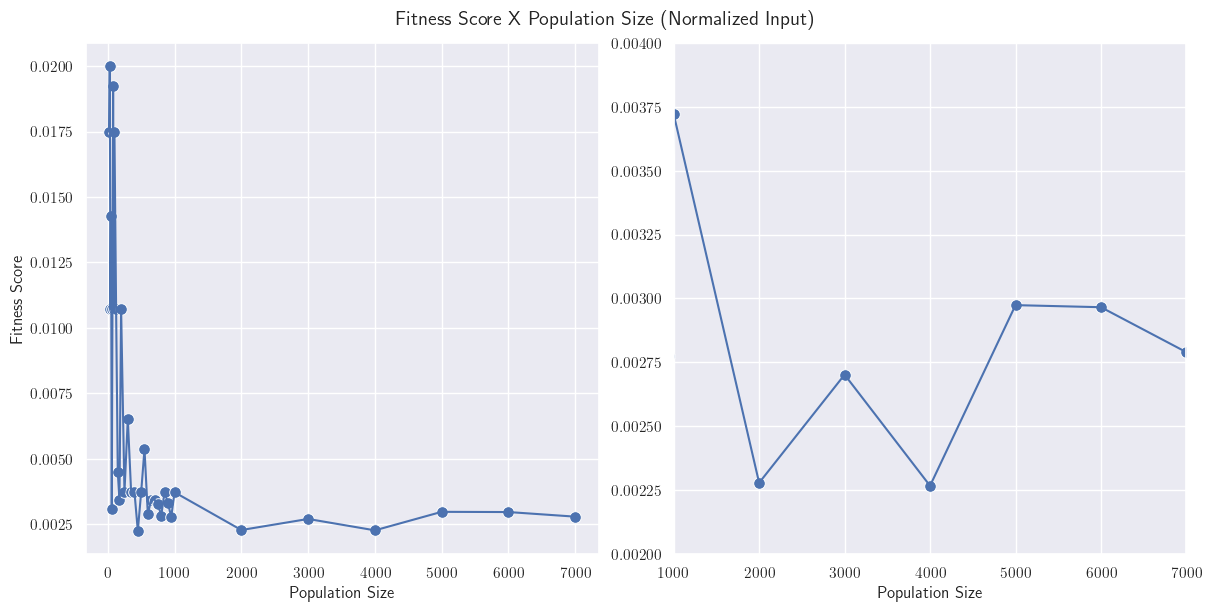

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
plt.suptitle("Fitness Score X Population Size (Normalized Input)")


sns.lineplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0]) 
sns.scatterplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0], s=70)


for ax in axs:
    ax.set_xlabel("Population Size")
    ax.set_ylabel("Fitness Score")
    
axs[1].set_xlim((1000, 7000))
axs[1].set_ylim((0.0020, 0.0040))
axs[1].set_ylabel(" ", visible=False)


sns.lineplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1])
sns.scatterplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1], s=70)
plt.show()

## Training Time X Population Size

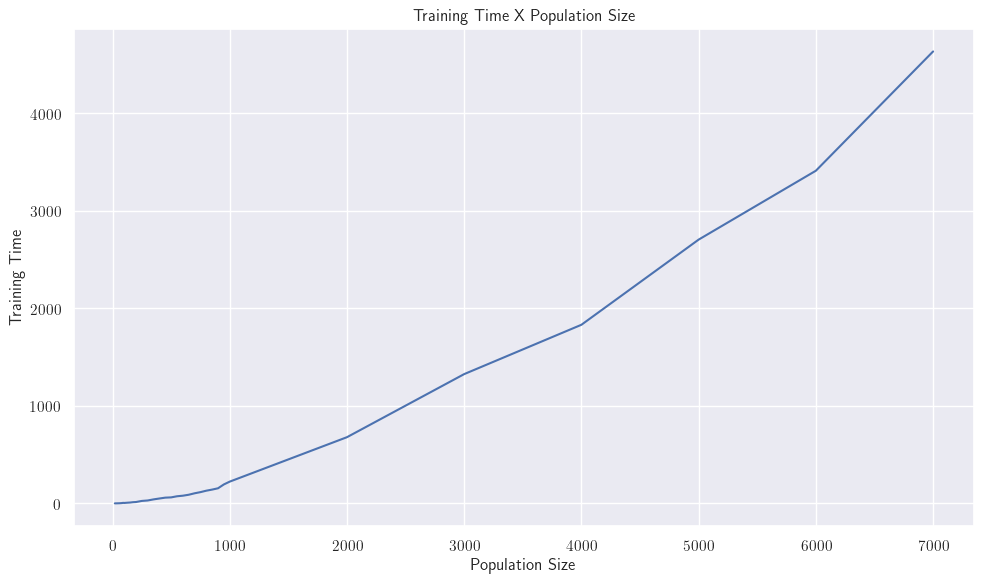

In [12]:
plt.figure(figsize=(10, 6))
plt.title("Training Time X Population Size ")

sns.lineplot(data, x=data.population_size, y=data["training_time"]) 
plt.tight_layout()

plt.xlabel("Population Size")
plt.ylabel("Training Time")

plt.show()

## Best Fit
Como os dados foram normalizados, o valor bruto do erro diminuí, simplesmentes pelos valores brutos serem menores. Concertamos esse erro para a escala real

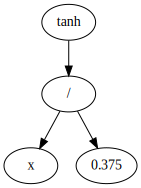

In [13]:
best_tree = data.sort_values("fitness_score", axis=0)
best_tree = best_tree.reset_index(drop=True)
best_index = str(best_tree.population_size[0])

img_path = path + "trees/tree-" + best_index

best_data = pd.read_csv(path + f"data/data-{best_index}.csv")
display(SVG(img_path + ".svg"))

In [14]:
X = np.linspace(0, 15, 1000)
y = func(X)

X_range = X.max() - X.min()
y_range = y.max() - y.min()

def output_func(X):
    return np.tanh((X - X.min())/(0.375 * X_range))*y_range + y.min()

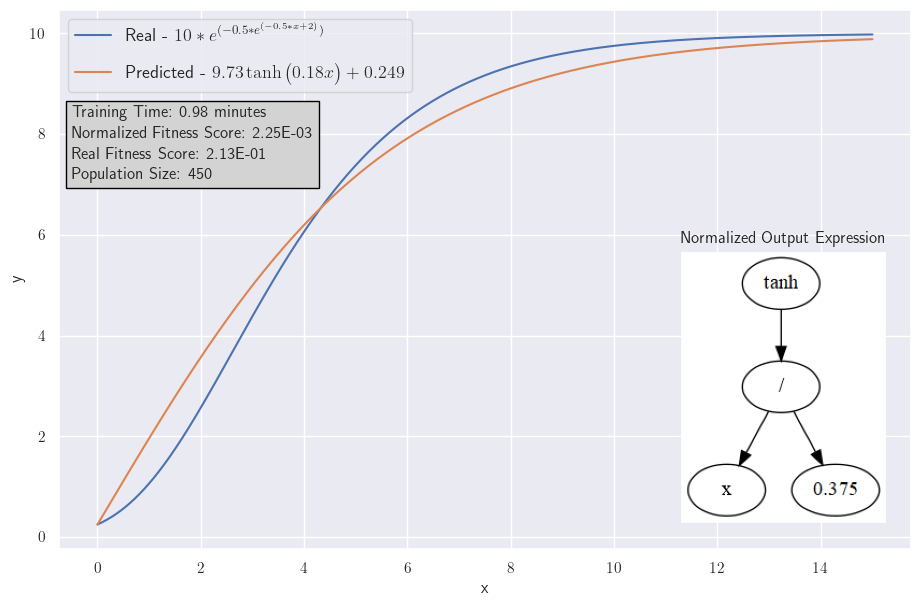

In [15]:
plt.figure(figsize=(11, 7))
plt.tight_layout()

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$")
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.73\tanh\Big(0.18x\Big) + 0.249$")

plt.annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}
Population Size: {best_index}""", 
            (-0.5, 7.1), bbox={"facecolor": "lightgray", "edgecolor": "black"},
            linespacing = 1.5)


img = plt_svg(img_path)
ins = plt.gca().inset_axes([0.6, 0.05, 0.5, 0.5])
ins.imshow(img)
ins.get_xaxis().set_visible(False)
ins.get_yaxis().set_visible(False)
ins.set_title(f"Normalized Output Expression")

plt.ylabel("y")
plt.xlabel("x")

plt.legend(prop={"size": 13}, labelspacing=1, loc="upper left")
plt.show()

## Lest Squares Fit

In [16]:
def model(X, a, b, c, d):
    return a * np.tanh(b*X + c) + d

params = least_squares_fit(model, X, y, [1, 1, 1, 1])
params

array([ 5.94633557,  0.29071247, -0.81410775,  4.00065131])

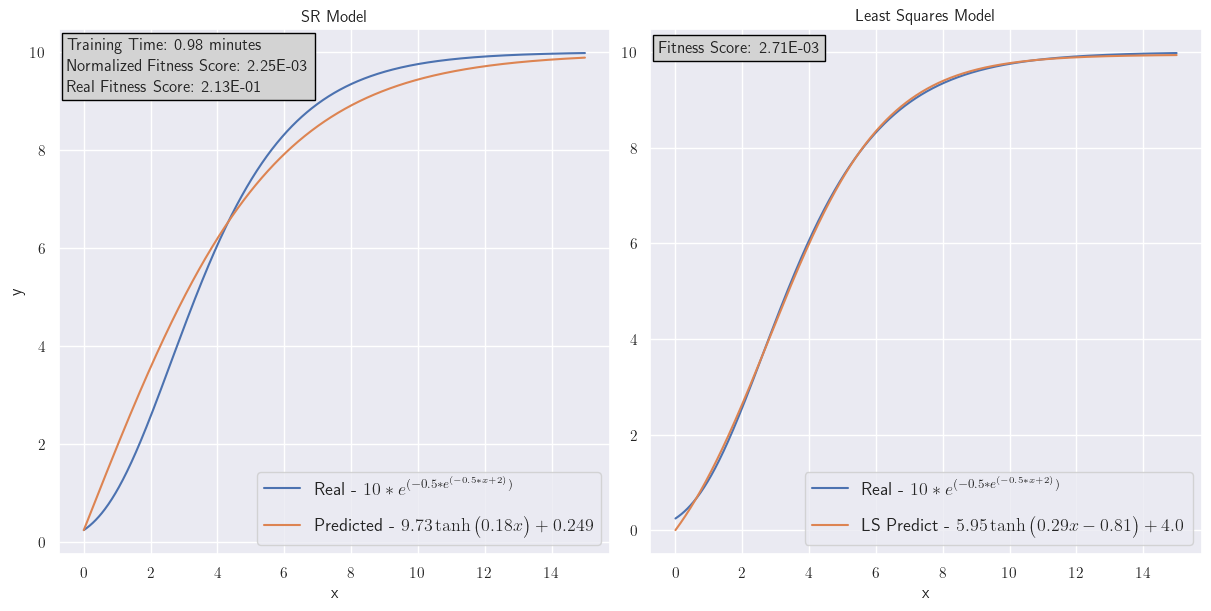

In [17]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[0])
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.73\tanh\Big(0.18x\Big) + 0.249$", ax=axs[0])


# Axis 1
axs[0].annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}""", 
            (-0.5, 9.2), bbox={"facecolor": "lightgray", "edgecolor": "black"},
               linespacing = 1.5)

axs[0].legend(prop={"size": 13}, labelspacing=1)
axs[0].set_ylabel("y")
axs[0].set_xlabel("x")
axs[0].set_title("SR Model")


# Axis 2
sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[1])
sns.lineplot(x=X, y=model(X, *params), ax=axs[1], label=r"LS Predict - $5.95\tanh \Big(0.29x - 0.81\Big) + 4.0$")
axs[1].legend(prop={"size": 13}, labelspacing=1)
axs[1].set_xlabel("x")

axs[1].annotate(f"""Fitness Score: {least_squares(X, y, model, *params):.2E}""", 
            (-0.5, 10), bbox={"facecolor": "lightgray", "edgecolor": "black"})
axs[1].set_title("Least Squares Model")

plt.show()

## 🔷 Conclusões
- Erro do método continua no ordem de $10^{-1}$
- A complexidade não muda
- Um modelo, para a mesma função, porém com as constantes ajustadas chegou a um erro da ordem de $10^{-3}$
- Até então o modelo estava limitado pelo intervalo das constantes, o que poderia não dar a ele completa liberdade.

Escolhi fazer os testes de mínimo quadrado para a mesma função que o modelo descobriu, pois descobrir a função é o intuíto do algoritmo e, obviamente, se fornecermos a função correta o algoritmo de mínimo quadrados será mais eficiente em encontrar a solução. 

# 🔵 Output Changing Constants Range

Equation
$$10*\exp(-0.5*exp(-0.5*x + 2))$$
- X range: (0, 15)

- Max generations = 3
- max_expression_size: 3
- max_island_count: population/10

- 🔴 Normalized input (range from 0 to 1)
- 🔴 Constants range from -10 to 10

In [18]:
path = "output_const_range/"
img_path = path + "trees/"
data_path = path + "data/"

data = pd.read_csv(path + cleaned_results)

## Fitness X Population Size

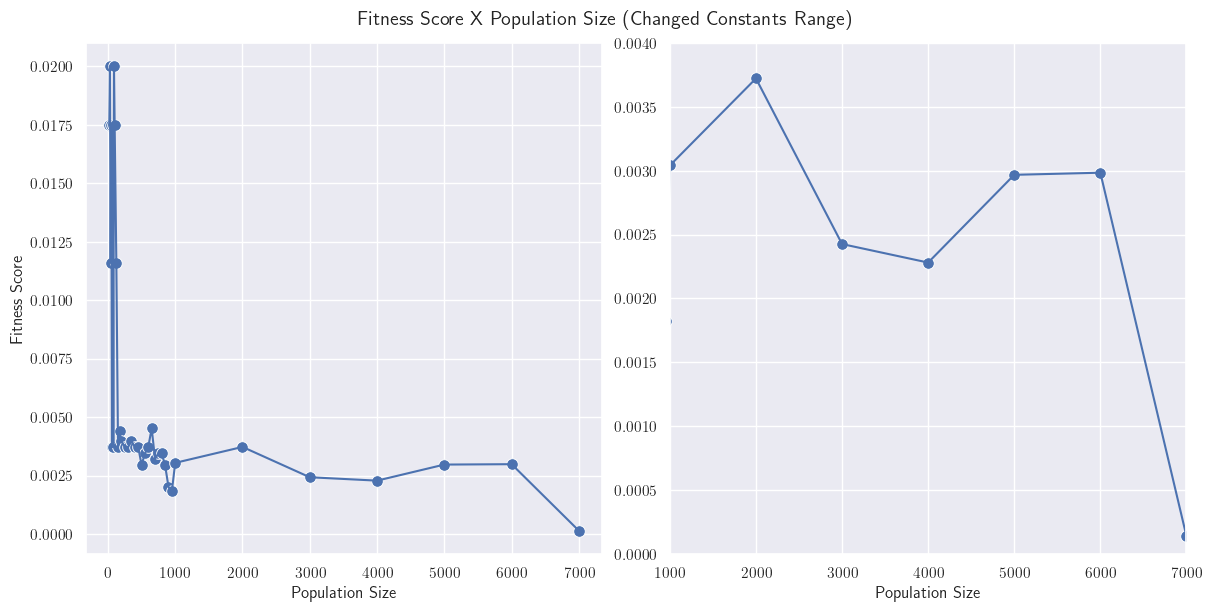

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
plt.suptitle("Fitness Score X Population Size (Changed Constants Range)")


sns.lineplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0])
sns.scatterplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0], s=70)


for ax in axs:
    ax.set_xlabel("Population Size")
    ax.set_ylabel("Fitness Score")
    
axs[1].set_xlim((1000, 7000))
axs[1].set_ylim((0, 0.0040))
axs[1].set_ylabel(" ", visible=False)


sns.lineplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1])
sns.scatterplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1], s=70)
plt.show()

## Training Time X Population Size

In [20]:
no_outlier_data = data.drop(32, axis=0)

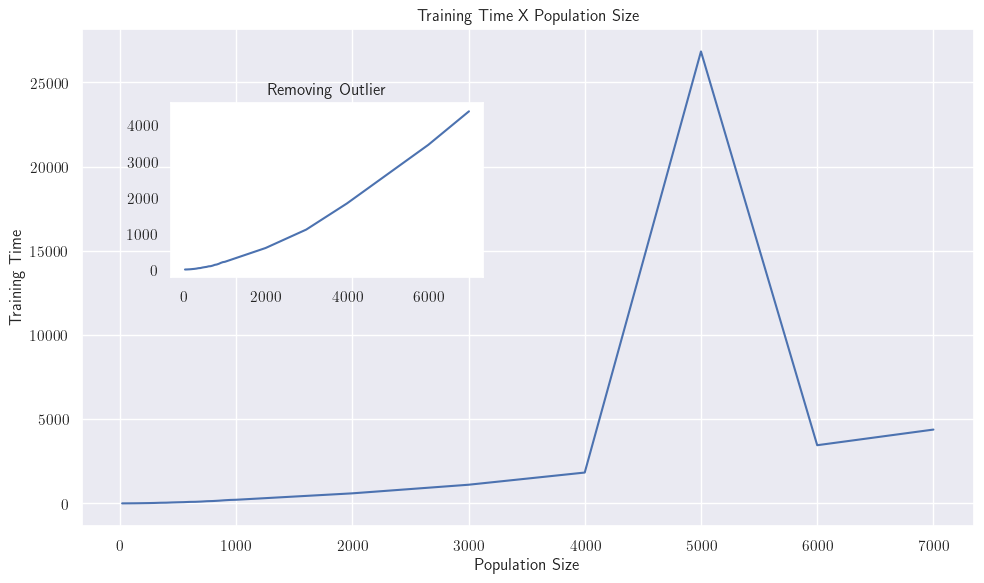

In [21]:
plt.figure(figsize=(10, 6))
plt.title("Training Time X Population Size ")

sns.lineplot(data, x=data.population_size, y=data["training_time"]) 

ins = plt.gca().inset_axes([0.1, 0.5, 0.35, 0.35])
ins.set_facecolor("white")
ins.set_ylabel(" ", visible=False)
ins.set_xlabel(" ", visible=False)
ins.set_title("Removing Outlier")

sns.set_style("white")
sns.lineplot(data, x=no_outlier_data.population_size, y=no_outlier_data["training_time"], ax=ins) 
sns.set()
plt.tight_layout()

plt.xlabel("Population Size")
plt.ylabel("Training Time")

plt.show()

## Best Fit
É a primeira vez que abaixamos uma ordem do erro real

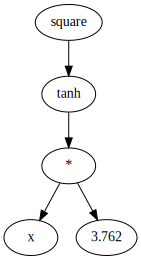

In [22]:
best_tree = data.sort_values("fitness_score", axis=0)
best_tree = best_tree.reset_index(drop=True)
best_index = str(best_tree.population_size[0])

img_path = path + "trees/tree-" + best_index

best_data = pd.read_csv(path + f"data/data-{best_index}.csv")
SVG(img_path + ".svg")

In [23]:
X = np.linspace(0, 15, 1000)
y = func(X)

X_range = X.max() - X.min()
y_range = y.max() - y.min()

def output_func(X):
    # return (np.tanh(3.762*X))**2
    return (np.tanh(3.762*(X - X.min())/(X_range)))**2 * y_range + y.min()

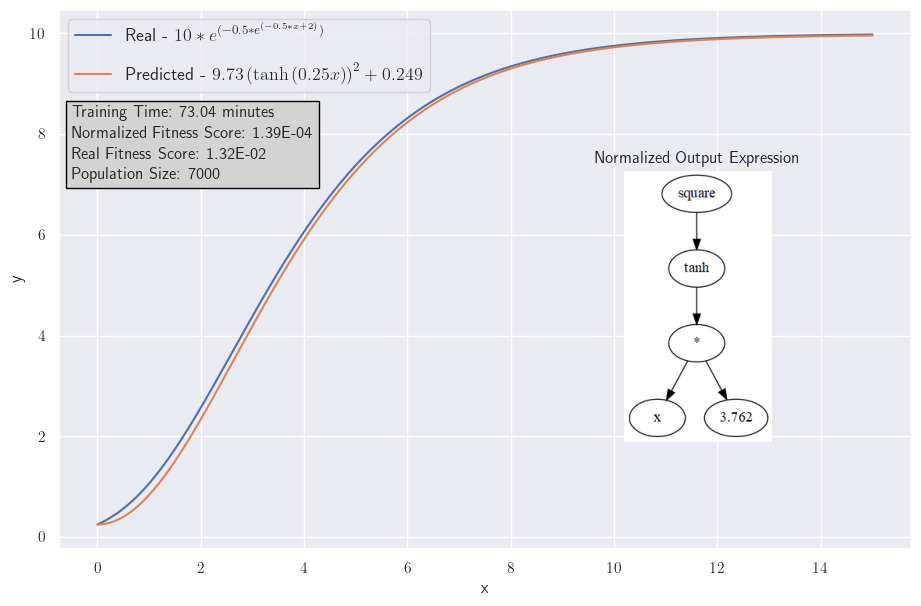

In [24]:
plt.rcParams['text.usetex'] = True

plt.figure(figsize=(11, 7))
plt.tight_layout()

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$")
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.73\left(\tanh\left(0.25x\right)\right)^2 + 0.249$")

plt.annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}
Population Size: {best_index}""", 
            (-0.5, 7.1), bbox={"facecolor": "lightgray", "edgecolor": "black"},
            linespacing = 1.5)

img = plt_svg(img_path)
ins = plt.gca().inset_axes([0.5, 0.2, 0.5, 0.5])
ins.imshow(img)
ins.get_xaxis().set_visible(False)
ins.get_yaxis().set_visible(False)
ins.set_title(f"Normalized Output Expression")


plt.ylabel("y")
plt.xlabel("x")

plt.legend(prop={"size": 13}, labelspacing=1, loc="upper left")
plt.show()

## Lest Squares Fit

In [25]:
def model(X, a, b, c, d, e, f):
    return a*(b * np.tanh(c*X + d) + e)**2 + f

params = least_squares_fit(model, X, y, [1, 1, 1, 1, 1, 1])
params

array([ 1.37956513,  2.28262819,  0.25425682, -0.07690432,  0.37971209,
        0.216474  ])

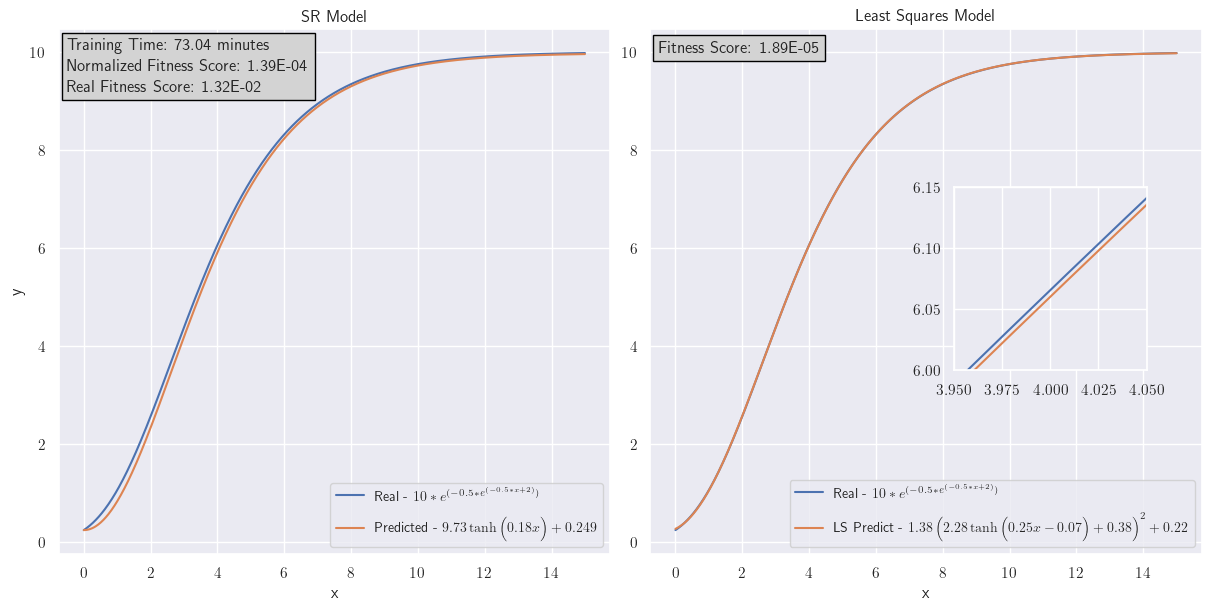

In [26]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[0])
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.73\tanh\Big(0.18x\Big) + 0.249$", ax=axs[0])


# Axis 1
axs[0].annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}""", 
            (-0.5, 9.2), bbox={"facecolor": "lightgray", "edgecolor": "black"},
               linespacing = 1.5)

axs[0].legend(prop={"size": 10}, labelspacing=1)
axs[0].set_ylabel("y")
axs[0].set_xlabel("x")
axs[0].set_title("SR Model")


# Axis 2
sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[1])
sns.lineplot(x=X, y=model(X, *params), ax=axs[1], label=r"LS Predict - $1.38\left(2.28 \tanh\Big(0.25x -0.07\Big) + 0.38\right)^2 + 0.22$")
axs[1].legend(prop={"size": 10}, labelspacing=1)
axs[1].set_xlabel("x")

axs[1].annotate(f"""Fitness Score: {least_squares(X, y, model, *params):.2E}""", 
            (-0.5, 10), bbox={"facecolor": "lightgray", "edgecolor": "black"})
axs[1].set_title("Least Squares Model")

ins = axs[1].inset_axes([0.55, 0.35, 0.35, 0.35])
sns.lineplot(x=X, y=func(X), ax=ins)
sns.lineplot(x=X, y=model(X, *params), ax=ins)
ins.set_xlim((3.95,4.05))
ins.set_ylim((6,6.15))

plt.show()

## 🔷 Conclusões
- O erro, pela primeira vez, chegou a ordem de $10^{-2}$
- O erro com as constantes ajustadas chegou a ordem de $10^{-5}$
- Apesar do outlier no tempo de execução, ele se manteve com complexidde exponencial
- Observamos que a solução original incluí uma constate fora do intervalo anterior de (0,1). Ou seja, esse também é um hiperparâmetro muito importante a ser considerado

Até então utilizamos um intervalo de (0, 15) para os dados de entrada, porém, isso limita as informações para o modelo, além de que ele não é capaz de reproduzir o comportamento dessa parte da função. Por isso, vamos expandir o intervalo dos dados.

# 🔵 Output Intensified
Nos casos "intensificados", aumentamos o intervalo dos dados, afim de mostrar melhor o comportamento da função.

Equation
$$10*\exp(-0.5*exp(-0.5*x + 2))$$
- 🔴 X range: (-5, 15)

- Max generations = 3
- max_expression_size: 3
- max_island_count: population/10

- 🔴 Non Normalized input
- 🔴 Constants range from -10 to 10

In [27]:
path = "output_intensified/"
img_path = path + "trees/"
data_path = path + "data/"

data = pd.read_csv(path + cleaned_results)

## Fitness X Population Size
Os resultados para o intervalo "intensificado" e não normalizado foram horríveis

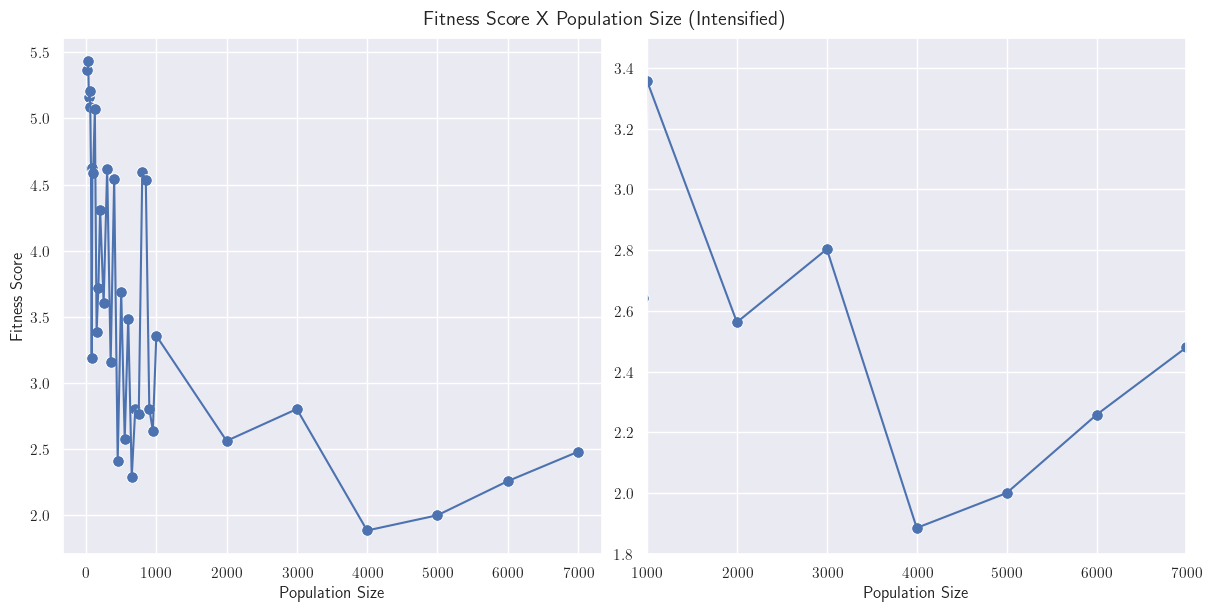

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
plt.suptitle("Fitness Score X Population Size (Intensified)")


sns.lineplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0]) 
sns.scatterplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0], s=70)


for ax in axs:
    ax.set_xlabel("Population Size")
    ax.set_ylabel("Fitness Score")
    
axs[1].set_xlim((1000, 7000))
axs[1].set_ylim((1.8, 3.5))
axs[1].set_ylabel(" ", visible=False)


sns.lineplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1])
sns.scatterplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1], s=70)
plt.show()

## Training Time X Population Size

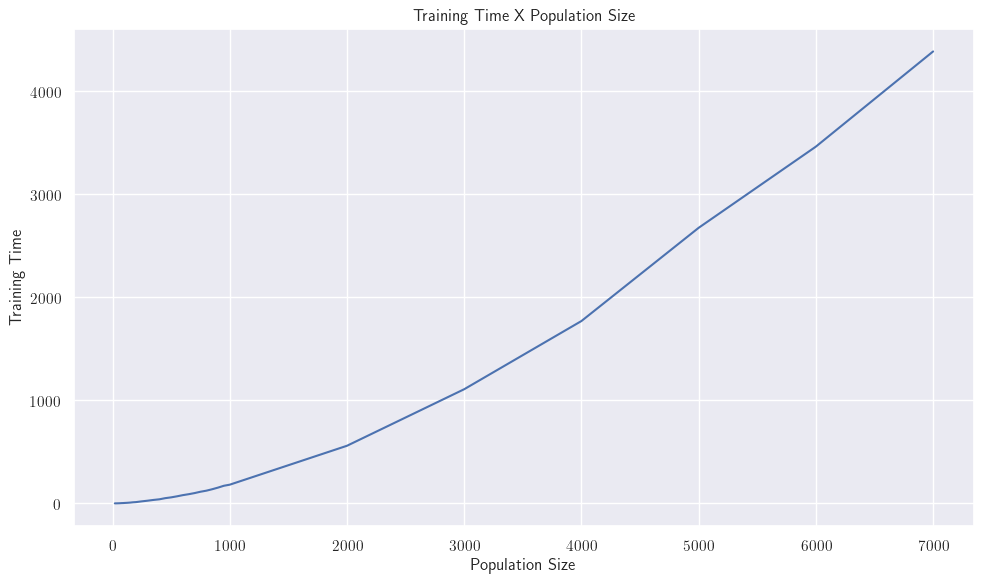

In [29]:
plt.figure(figsize=(10, 6))
plt.title("Training Time X Population Size ")

sns.lineplot(data, x=data.population_size, y=data["training_time"]) 

sns.set_style("white")
sns.lineplot(data, x=data.population_size, y=data["training_time"], ax=ins) 
sns.set()
plt.tight_layout()

plt.xlabel("Population Size")
plt.ylabel("Training Time")

plt.show()

## Best Fit

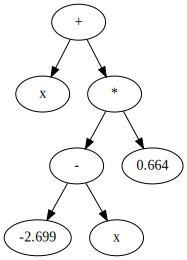

In [30]:
best_tree = data.sort_values("fitness_score", axis=0)
best_tree = best_tree.reset_index(drop=True)
best_index = str(best_tree.population_size[0])

img_path = path + "trees/tree-" + best_index

best_data = pd.read_csv(path + f"data/data-{best_index}.csv")
SVG(img_path + ".svg")

In [31]:
X = best_data.x
y = func(X)

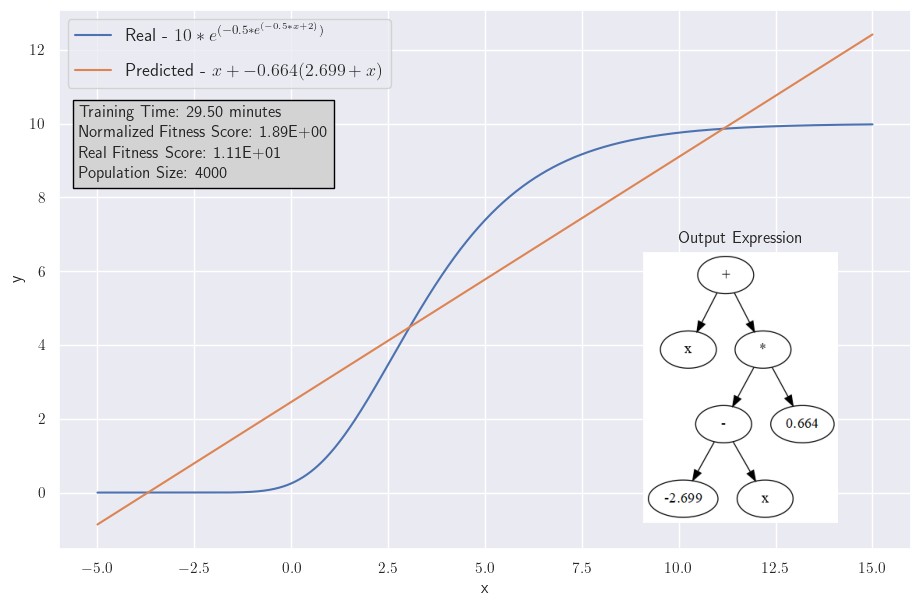

In [32]:
plt.rcParams['text.usetex'] = True

plt.figure(figsize=(11, 7))
plt.tight_layout()

sns.lineplot(x=best_data.x, y=func(best_data.x), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$")
sns.lineplot(x=best_data.x, y=best_data.y, label=r"Predicted - $x+-0.664(2.699 + x)$")

plt.annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}
Population Size: {best_index}""", 
            (-5.48, 8.5), bbox={"facecolor": "lightgray", "edgecolor": "black"},
            linespacing = 1.5)

img = plt_svg(img_path)
ins = plt.gca().inset_axes([0.55, 0.05, 0.5, 0.5])
ins.imshow(img)
ins.get_xaxis().set_visible(False)
ins.get_yaxis().set_visible(False)
ins.set_title(f"Output Expression")


plt.ylabel("y")
plt.xlabel("x")

plt.legend(prop={"size": 13}, labelspacing=1, loc="upper left")
plt.show()

## Lest Squares Fit

In [33]:
def model(X, a, b):
    return a * X + b

params = least_squares_fit(model, X, y, [1, 1])
params

array([0.68943329, 2.17017923])

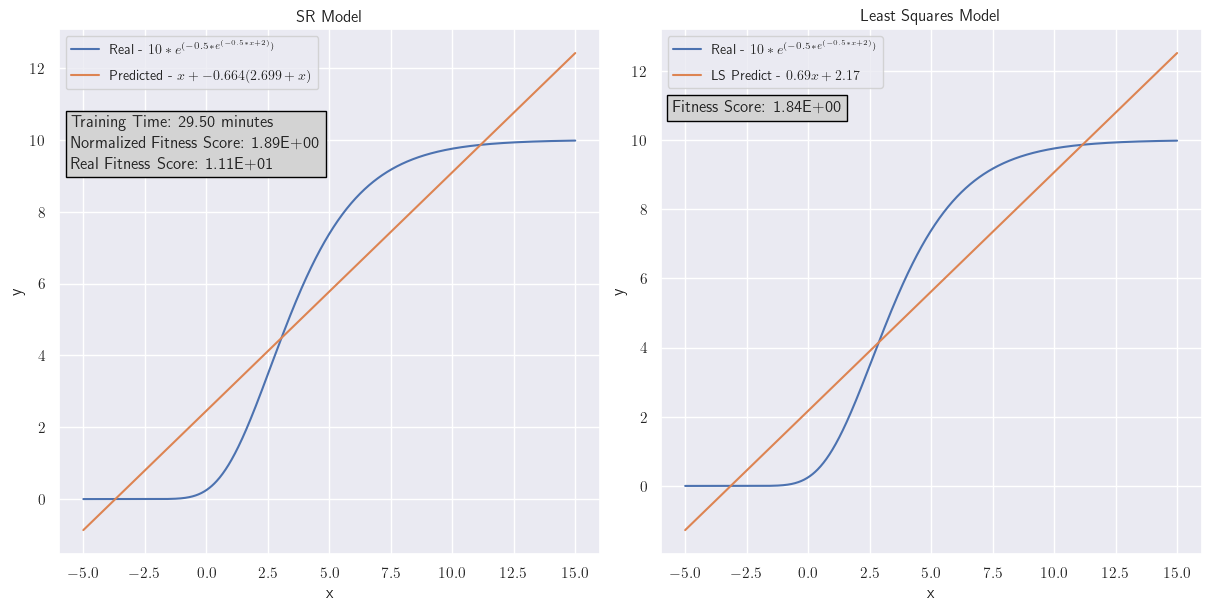

In [34]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[0])
sns.lineplot(x=X, y=best_data.y, label=r"Predicted - $x+-0.664(2.699 + x)$", ax=axs[0])


# Axis 1
axs[0].annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}""", 
            (-5.5, 9.2), bbox={"facecolor": "lightgray", "edgecolor": "black"},
               linespacing = 1.5)

axs[0].legend(prop={"size": 10}, labelspacing=1)
axs[0].set_ylabel("y")
axs[0].set_xlabel("x")
axs[0].set_title("SR Model")


# Axis 2
sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[1])
sns.lineplot(x=X, y=model(X, *params), ax=axs[1], label=r"LS Predict - $0.69x + 2.17$")
axs[1].legend(prop={"size": 10}, labelspacing=1)
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")

axs[1].annotate(f"""Fitness Score: {least_squares(X, y, model, *params):.2E}""", 
            (-5.5, 10.8), bbox={"facecolor": "lightgray", "edgecolor": "black"})
axs[1].set_title("Least Squares Model")

plt.show()

## 🔷 Conclusões
- O algoritmo não convergiu e não conseguiu encontrar uma solução que descreva a curva

Isso implica que, dependendo do intervalo de dados fornecidos, o algoritmo pode ter uma maior dificuldade de encontrar qualquer solução. 

# Output Normalized Intensified 

Equation
$$10*\exp(-0.5*exp(-0.5*x + 2))$$
- 🔴 X range: (-5, 15)

- Max generations = 3
- max_expression_size: 3
- max_island_count: population/10

- 🔴 Normalized input (range from 0 to 1)
- 🔴 Constants range from -10 to 10

In [35]:
path = "output_inten_scaled/"
img_path = path + "trees/"
data_path = path + "data/"

data = pd.read_csv(path + cleaned_results)

## Fitness X Population Size

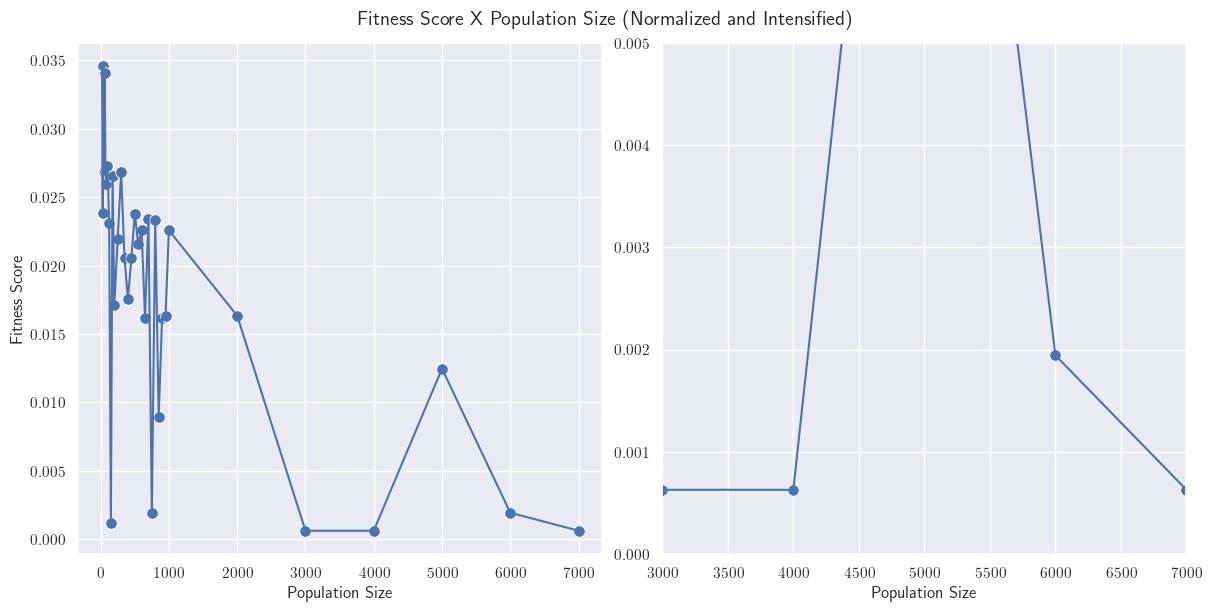

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
plt.suptitle("Fitness Score X Population Size (Normalized and Intensified)")


sns.lineplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0]) 
sns.scatterplot(data, x=data.population_size, y=data["fitness_score"], ax=axs[0], s=70)

for ax in axs:
    ax.set_xlabel("Population Size")
    ax.set_ylabel("Fitness Score")
    
axs[1].set_xlim(3000, 7000)
axs[1].set_ylim((0, 0.0050))
axs[1].set_ylabel(" ", visible=False)


sns.lineplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1])
sns.scatterplot(data, x=data.population_size, y=data.fitness_score, ax=axs[1], s=70)
plt.show()

## Training Time X Population Size

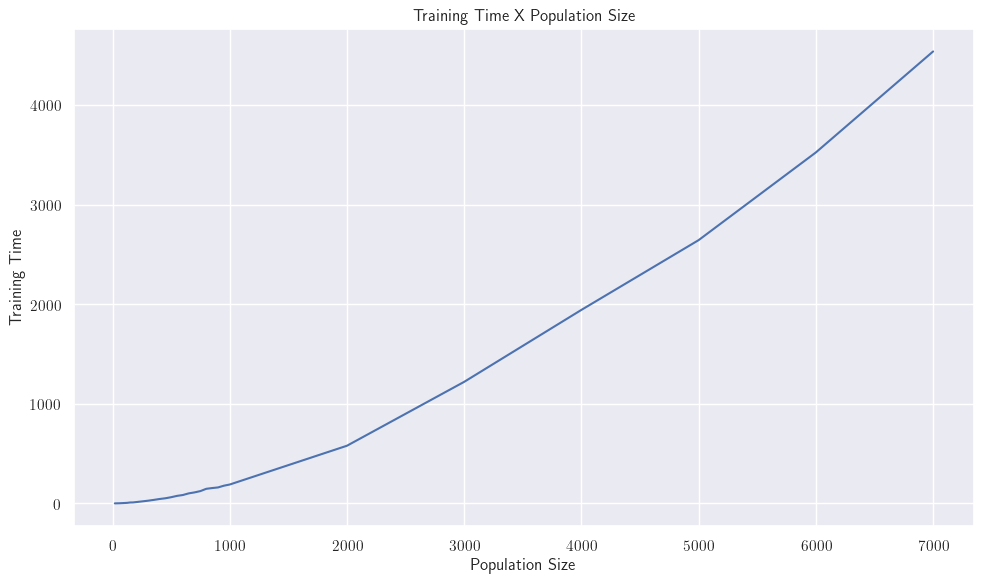

In [37]:
plt.figure(figsize=(10, 6))
plt.title("Training Time X Population Size ")

sns.lineplot(data, x=data.population_size, y=data["training_time"]) 

sns.set_style("white")
sns.lineplot(data, x=data.population_size, y=data["training_time"], ax=ins) 
sns.set()
plt.tight_layout()

plt.xlabel("Population Size")
plt.ylabel("Training Time")

plt.show()

## Best Fit

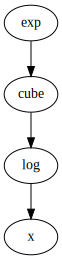

In [38]:
best_tree = data.sort_values("fitness_score", axis=0)
best_tree = best_tree.reset_index(drop=True)
best_index = str(best_tree.population_size[0])

img_path = path + "trees/tree-" + best_index

best_data = pd.read_csv(path + f"data/data-{best_index}.csv")
SVG(img_path + ".svg")

In [39]:
X = np.linspace(-5, 15, 1000)
y = func(X)

X_range = X.max() - X.min()
y_range = y.max() - y.min()

def output_func(X):
    # return (np.tanh(3.762*(X - X.min())/(X_range)))**2 * y_range + y.min()
    return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()

$$9.98\exp\left(\ln^3\left(0.05x + 0.25\right)\right)$$

C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()


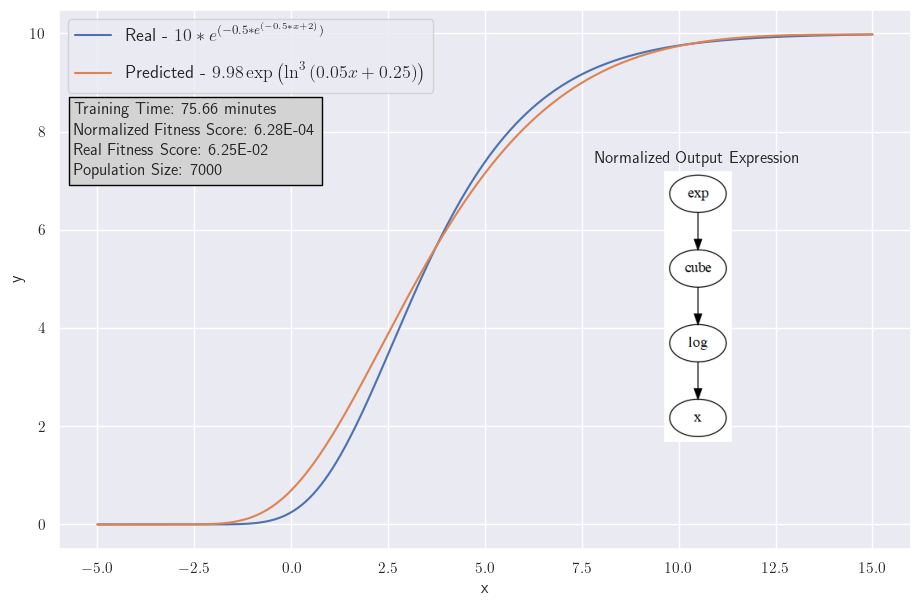

In [40]:
plt.figure(figsize=(11, 7))
plt.tight_layout()

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$")
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.98\exp\left(\ln^3\left(0.05x + 0.25\right)\right)$")

plt.annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}
Population Size: {best_index}""", 
            (-5.6, 7.1), bbox={"facecolor": "lightgray", "edgecolor": "black"},
            linespacing = 1.5)

img = plt_svg(img_path)
ins = plt.gca().inset_axes([0.5, 0.2, 0.5, 0.5])
ins.imshow(img)
ins.get_xaxis().set_visible(False)
ins.get_yaxis().set_visible(False)
ins.set_title(f"Normalized Output Expression")


plt.ylabel("y")
plt.xlabel("x")

plt.legend(prop={"size": 13}, labelspacing=1, loc="upper left")
plt.show()

## Lest Squares Fit

In [41]:
def model(X, a, b, c, d, e):
    return a*np.exp(d*(np.log(c*X) +e)**3 ) + b 

scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(np.c_[X]).reshape(1000, )
y_scaled = scaler.fit_transform(np.c_[y]).reshape(1000, )

params = least_squares_fit(model, X_scaled, y_scaled, [1, 1, 1, 1, 1])
params

C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\1098609051.py:2: RuntimeWarning: divide by zero encountered in log
  return a*np.exp(d*(np.log(c*X) +e)**3 ) + b
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\1098609051.py:2: RuntimeWarning: invalid value encountered in log
  return a*np.exp(d*(np.log(c*X) +e)**3 ) + b


array([ 0.99073414, -0.00250642,  0.34961345,  1.77810566,  1.19440164])

$$0.99e^{1.78\big(\ln(0.35x) + 1.19\big)^3} - 0.0025$$

In [42]:
def model(X, a, b, c, d, e):
    return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.min()

C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2754879685.py:2: RuntimeWarning: divide by zero encountered in log
  return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2754879685.py:2: RuntimeWarning: divide by zero encountered in log
  return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2754879685.py:2: RuntimeWarning: divide by zero encountered in log
  return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.mi

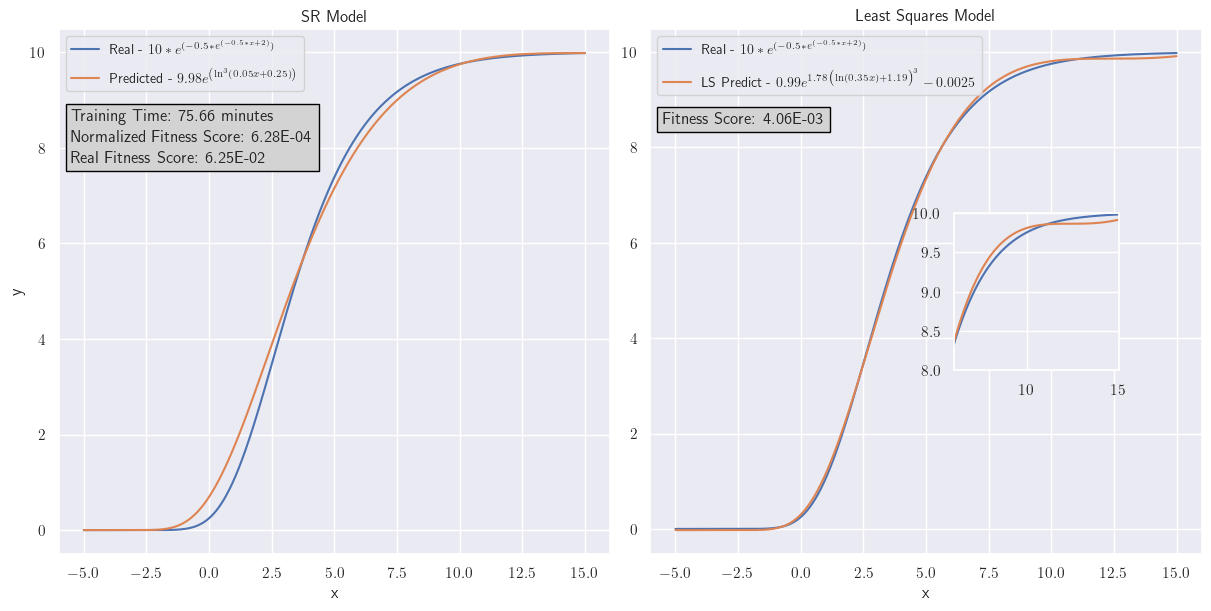

In [43]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[0])
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.98e^{\left(\ln^3\left(0.05x + 0.25\right)\right)}$", ax=axs[0])


# Axis 1
axs[0].annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}""", 
            (-5.5, 7.7), bbox={"facecolor": "lightgray", "edgecolor": "black"},
               linespacing = 1.5)

axs[0].legend(prop={"size": 10}, labelspacing=1)
axs[0].set_ylabel("y")
axs[0].set_xlabel("x")
axs[0].set_title("SR Model")


# Axis 2
sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[1])
sns.lineplot(x=X, y=model(X, *params), ax=axs[1], label=r"LS Predict - $0.99e^{1.78\big(\ln(0.35x) + 1.19\big)^3} - 0.0025$")
axs[1].legend(prop={"size": 10}, labelspacing=1, loc = "upper left")
axs[1].set_xlabel("x")

axs[1].annotate(f"""Fitness Score: {least_squares(X, y, model, *params):.2E}""", 
            (-5.5, 8.5), bbox={"facecolor": "lightgray", "edgecolor": "black"})
axs[1].set_title("Least Squares Model")

ins = axs[1].inset_axes([0.55, 0.35, 0.30, 0.30])
sns.lineplot(x=X, y=func(X), ax=ins)
sns.lineplot(x=X, y=model(X, *params), ax=ins)
ins.set_xlim((6,15))
ins.set_ylim((8,10))

plt.show()

# Considerações

- Para o modelo normalizado obtivemos o mesmo resultado para a ordem do erro, do que para o caso não "intensificado". Porém, nesse caso, a curva encontrada descreve melhor nosso problema, de forma geral. Tendo em vista que anteriormente havia uma parte importante que não estava sendo considerada.
- Ele só encontrou a melhor solução para população = 7000 (segunda vez)
- O modelo da direita seria um caso de overfittig? Considerando que a função real tem aproximadamente o mesmo nível de complexidade
- Embora o resultado do modelo tenha sido tão bom quanto antes, o resultado para aquele com as constantes ajustadas não foi tão bom

A partir de agora iremos mudar alguns outros hiperparâmetros, tomando como base o modelo nesse estado - intensificado e normalizado

# 🔵 Output Changing Generations 

Equation
$$10*\exp(-0.5*exp(-0.5*x + 2))$$
- X range: (-5, 15)

- 🔴 Population size = 2000
- max_expression_size: 3
- max_island_count: population/10

- Normalized input (range from 0 to 1)
- Constants range from -10 to 10

In [44]:
path = "output_generations/"
img_path = path + "trees/"
data_path = path + "data/"

data = pd.read_csv(path + cleaned_results)

## Fitness Score X Max Generations

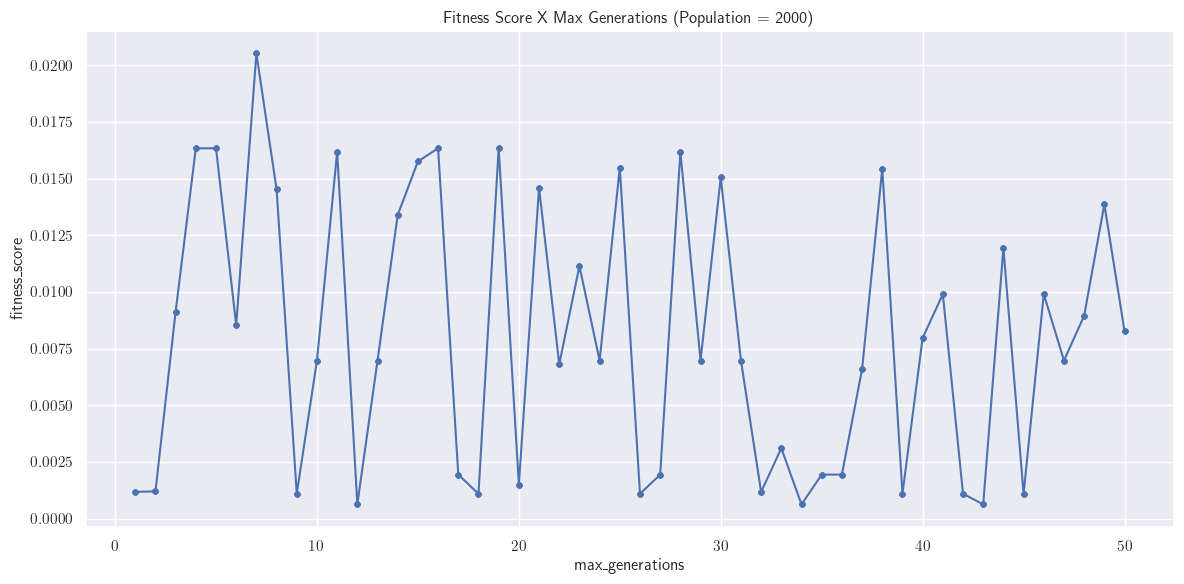

In [45]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

plt.figure(figsize=(12, 6))

sns.lineplot(data, x=data.max_generations, y=data["fitness_score"]) 
sns.scatterplot(data, x=data.max_generations, y=data["fitness_score"], s=30)

plt.title("Fitness Score X Max Generations (Population = 2000)")
plt.tight_layout()
plt.show()

## Training Time X Max Generation

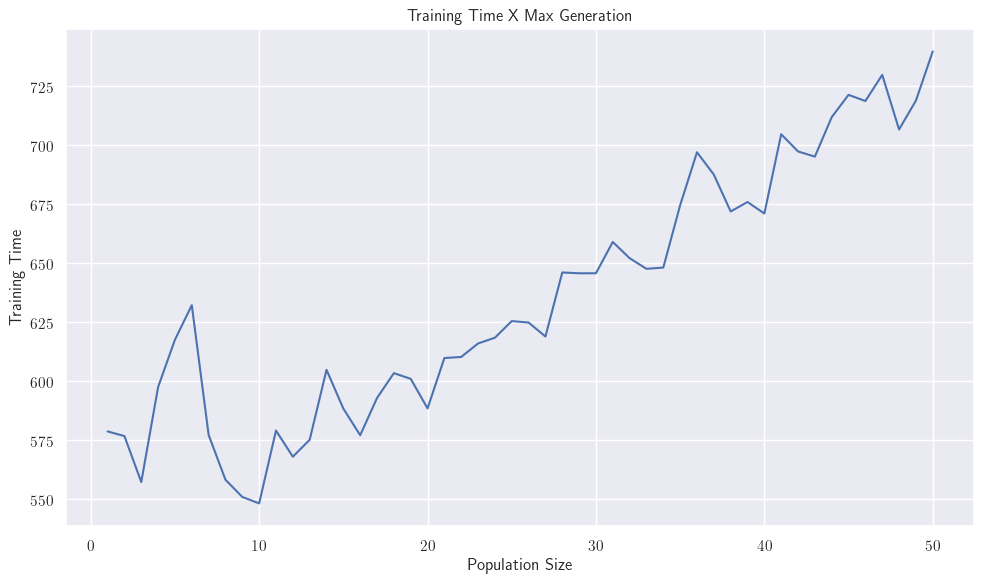

In [46]:
plt.figure(figsize=(10, 6))
plt.title("Training Time X Max Generation ")

sns.lineplot(data, x=data.max_generations, y=data["training_time"]) 

sns.set_style("white")
sns.lineplot(data, x=data.max_generations, y=data["training_time"], ax=ins) 
sns.set()
plt.tight_layout()

plt.xlabel("Population Size")
plt.ylabel("Training Time")

plt.show()

## Best Fit

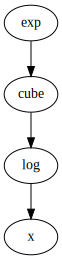

In [47]:
best_tree = data.sort_values("fitness_score", axis=0)
best_tree = best_tree.reset_index(drop=True)
best_index = str(best_tree.max_generations[0])


img_path = path + "trees/tree-" + best_index

best_data = pd.read_csv(path + f"data/data-{best_index}.csv")
SVG(img_path + ".svg")

In [48]:
X = np.linspace(-5, 15, 1000)
y = func(X)

X_range = X.max() - X.min()
y_range = y.max() - y.min()

def output_func(X):
    # return (np.tanh(3.762*(X - X.min())/(X_range)))**2 * y_range + y.min()
    return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()

$$9.98\exp\left(\ln^3\left(0.05x + 0.25\right)\right)$$

C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()


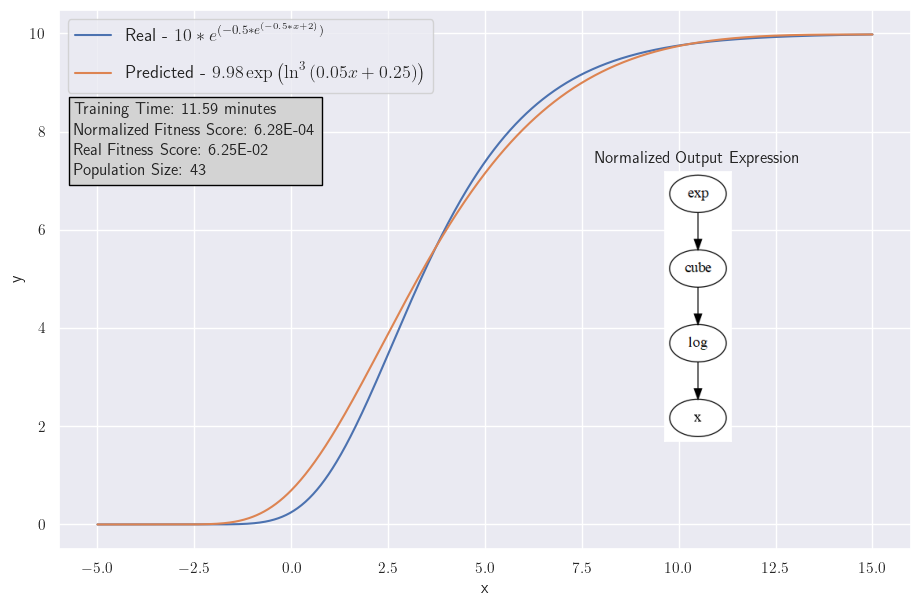

In [49]:
plt.figure(figsize=(11, 7))
plt.tight_layout()

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$")
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.98\exp\left(\ln^3\left(0.05x + 0.25\right)\right)$")

plt.annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}
Population Size: {best_index}""", 
            (-5.6, 7.1), bbox={"facecolor": "lightgray", "edgecolor": "black"},
            linespacing = 1.5)

img = plt_svg(img_path)
ins = plt.gca().inset_axes([0.5, 0.2, 0.5, 0.5])
ins.imshow(img)
ins.get_xaxis().set_visible(False)
ins.get_yaxis().set_visible(False)
ins.set_title(f"Normalized Output Expression")


plt.ylabel("y")
plt.xlabel("x")

plt.legend(prop={"size": 13}, labelspacing=1, loc="upper left")
plt.show()

## Lest Squares Fit

In [50]:
def model(X, a, b, c, d, e):
    return a*np.exp(d*(np.log(c*X) +e)**3 ) + b 

scaler = MinMaxScaler((0,1))
X_scaled = scaler.fit_transform(np.c_[X]).reshape(1000, )
y_scaled = scaler.fit_transform(np.c_[y]).reshape(1000, )

params = least_squares_fit(model, X_scaled, y_scaled, [1, 1, 1, 1, 1])
params

C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\1098609051.py:2: RuntimeWarning: divide by zero encountered in log
  return a*np.exp(d*(np.log(c*X) +e)**3 ) + b
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\1098609051.py:2: RuntimeWarning: invalid value encountered in log
  return a*np.exp(d*(np.log(c*X) +e)**3 ) + b


array([ 0.99073414, -0.00250642,  0.34961345,  1.77810566,  1.19440164])

$$0.99e^{1.78\big(\ln(0.35x) + 1.19\big)^3} - 0.0025$$

In [51]:
def model(X, a, b, c, d, e):
    return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.min()

C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2281423423.py:9: RuntimeWarning: divide by zero encountered in log
  return np.exp((np.log( (X - X.min())/X_range ))**3) * y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2754879685.py:2: RuntimeWarning: divide by zero encountered in log
  return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2754879685.py:2: RuntimeWarning: divide by zero encountered in log
  return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.min()
C:\Users\lreis\AppData\Local\Temp\ipykernel_5024\2754879685.py:2: RuntimeWarning: divide by zero encountered in log
  return (a * np.exp(d * (np.log(c*(X - X.min())/(X_range)) + e)**3) + b)*y_range + y.mi

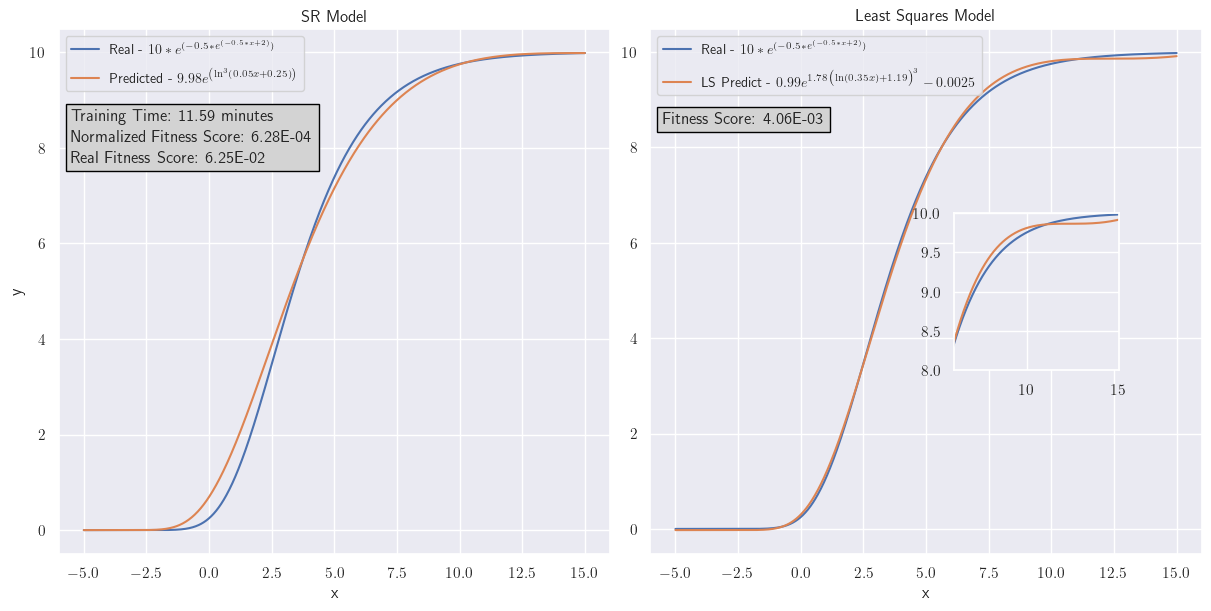

In [52]:
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 6))

sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[0])
sns.lineplot(x=X, y=output_func(X), label=r"Predicted - $9.98e^{\left(\ln^3\left(0.05x + 0.25\right)\right)}$", ax=axs[0])


# Axis 1
axs[0].annotate(f"""Training Time: {best_tree.training_time[0]/60.0:.2f} minutes
Normalized Fitness Score: {best_tree.fitness_score[0]:.2E}
Real Fitness Score: {least_squares(X, y, output_func):.2E}""", 
            (-5.5, 7.7), bbox={"facecolor": "lightgray", "edgecolor": "black"},
               linespacing = 1.5)

axs[0].legend(prop={"size": 10}, labelspacing=1)
axs[0].set_ylabel("y")
axs[0].set_xlabel("x")
axs[0].set_title("SR Model")


# Axis 2
sns.lineplot(x=X, y=func(X), label=r"Real - $10*e^{(-0.5*e^{(-0.5*x + 2)})}$", ax=axs[1])
sns.lineplot(x=X, y=model(X, *params), ax=axs[1], label=r"LS Predict - $0.99e^{1.78\big(\ln(0.35x) + 1.19\big)^3} - 0.0025$")
axs[1].legend(prop={"size": 10}, labelspacing=1, loc = "upper left")
axs[1].set_xlabel("x")

axs[1].annotate(f"""Fitness Score: {least_squares(X, y, model, *params):.2E}""", 
            (-5.5, 8.5), bbox={"facecolor": "lightgray", "edgecolor": "black"})
axs[1].set_title("Least Squares Model")

ins = axs[1].inset_axes([0.55, 0.35, 0.30, 0.30])
sns.lineplot(x=X, y=func(X), ax=ins)
sns.lineplot(x=X, y=model(X, *params), ax=ins)
ins.set_xlim((6,15))
ins.set_ylim((8,10))

plt.show()

## 🔷 Conclusões
- Talvez por deixar um número menor para a população, o algoritmo não estabilizou
- A complexidade ainda é exponencial, mas ainda com muita variação. Possivelmente devido a instabilidade do modelo para uma população de 2000
- Algumas curvas ganham um "pontos" a mais na fitness, por descreverem o comportamento assintótico de forma correta
- Obtemos a mesma solução do caso anterior para população = 7000
- O aumento do número de gerações não parece fazer o algoritmo atingir um ponto de equilíbrio
- Um problema que pode ter atrapalhado o algoritmo é a má fomulação da função de mutação (resolvido após os testes)

Essa conclusão é interessante, mesmo com o algoritimo não atingindo um ponto de equilíbrio, a mesma solução que para o caso de equilíbrio foi encontrada. Talvez por sorte?

# 🔵 Output Changing Expression Sizes

Equation
$$10*\exp(-0.5*exp(-0.5*x + 2))$$
- X range: (-5, 15)

- 🔴 Population size = 500 ou 2000
- 🔴 gerações: 20
- max_island_count: population/10

- Normalized input (range from 0 to 1)
- Constants range from -10 to 10

In [53]:
path = "output_expr_size/"

data1 = pd.read_csv(path + "test1/" + cleaned_results)
data2 = pd.read_csv(path + "test2/" + cleaned_results) 
data3 = pd.read_csv(path + "test3/" + cleaned_results) 

img_path = [path + f"test{i}/" + "trees/" for i in range(1,4)]
data_path = [path + f"test{i}/" + "data/" for i in range(1,4)]

## Fitness Score X Expression Size
Sem querer rodei o mesmo algoritmo duas vezes, devia ter mudado um parâmetro mas esqueci. Mas isso pode ser interessante para comparar diferentes runs aleatórias

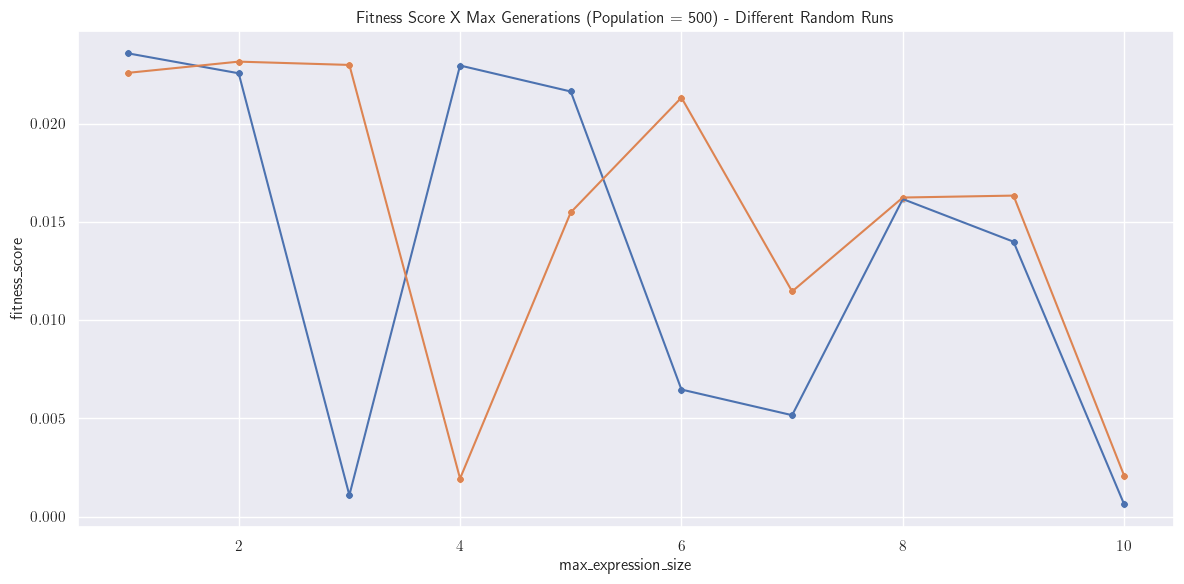

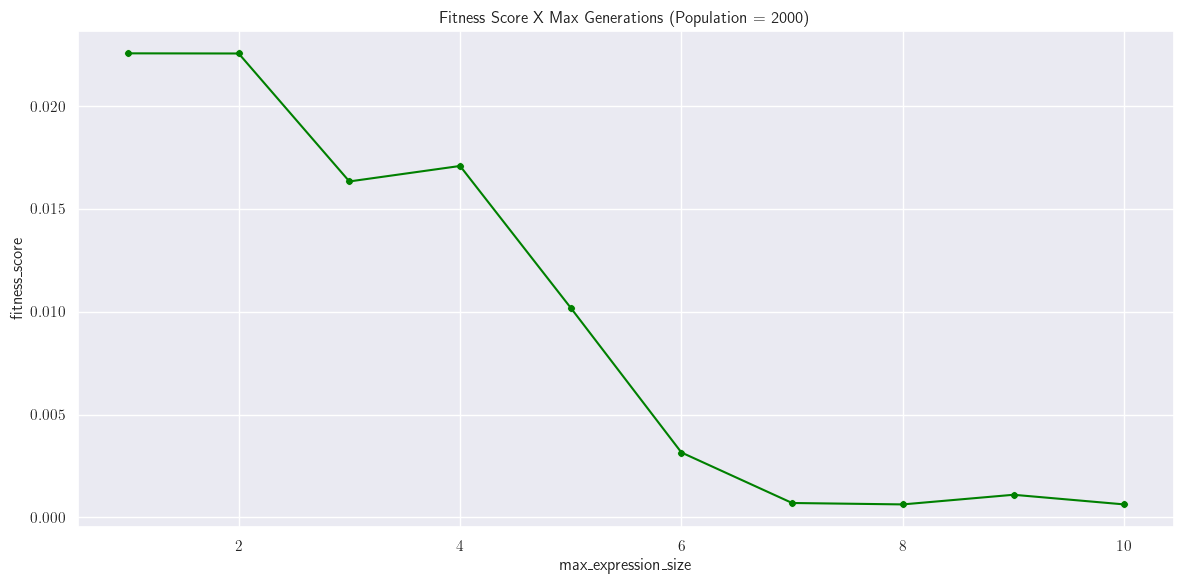

In [54]:
# fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

plt.figure(figsize=(12, 6))

sns.lineplot(data1, x=data1.max_expression_size, y=data1["fitness_score"]) 
sns.scatterplot(data1, x=data1.max_expression_size, y=data1["fitness_score"], s=30)


sns.lineplot(data2, x=data2.max_expression_size, y=data2["fitness_score"]) 
sns.scatterplot(data2, x=data2.max_expression_size, y=data2["fitness_score"], s=30)


plt.title("Fitness Score X Max Generations (Population = 500) - Different Random Runs")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
sns.lineplot(data3, x=data3.max_expression_size, y=data3["fitness_score"], c="green") 
sns.scatterplot(data3, x=data3.max_expression_size, y=data3["fitness_score"], s=30, c="green")


plt.title("Fitness Score X Max Generations (Population = 2000)")
plt.tight_layout()
plt.show()


## Training Time X Max Generation

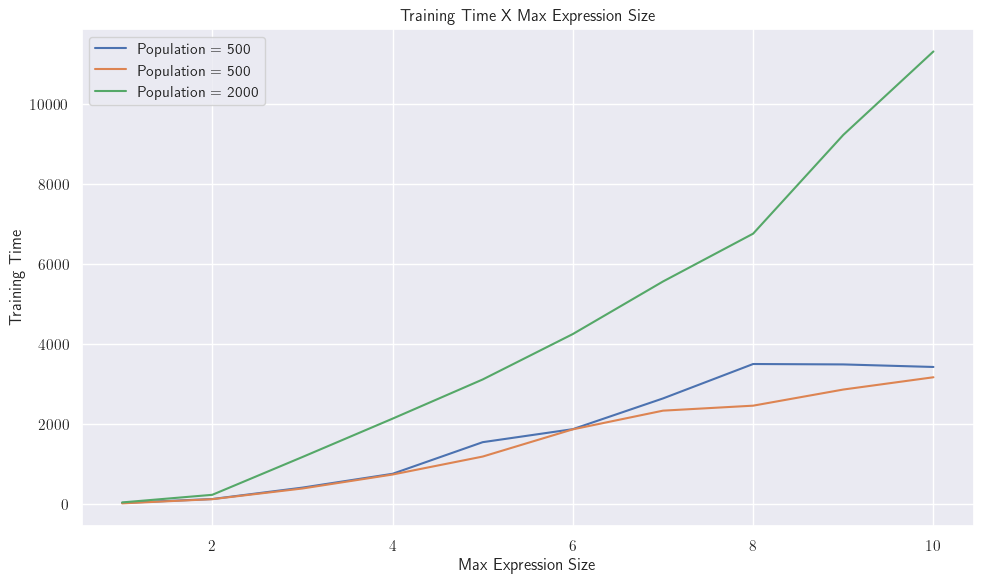

In [55]:
plt.figure(figsize=(10, 6))
plt.title("Training Time X Max Expression Size")

sns.lineplot(data1, x=data1.max_expression_size, y=data1["training_time"], label="Population = 500") 
sns.lineplot(data2, x=data2.max_expression_size, y=data2["training_time"], label="Population = 500") 
sns.lineplot(data3, x=data3.max_expression_size, y=data3["training_time"], label="Population = 2000") 

plt.tight_layout()
plt.xlabel("Max Expression Size")
plt.ylabel("Training Time")

plt.show()

## Best Fit

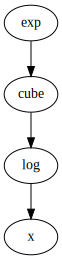

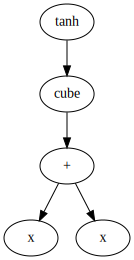

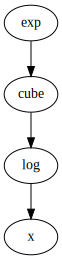

In [56]:
img_path = []
best_data = []

for i, data in enumerate([data1, data2, data3]):
    best_tree = data.sort_values("fitness_score", axis=0)
    best_tree = best_tree.reset_index(drop=True)
    best_index = str(best_tree.max_expression_size[0])
    
    img_path.append(path + f"test{i+1}/" + "trees/tree-" + best_index)

    best_data.append(pd.read_csv(path + f"test{i+1}/" +  f"data/data-{best_index}.csv"))
    display(SVG(img_path[i] + ".svg"))

# 🔵 Conclusões 
- Novamento observamos grande variação para o caso com baixa população
- Demora muito mais, quando se aumenta o número de expressões
- As mesmas soluções que os dois casos anteriores foram encontradas
    - Isso mostra que o tamanho das expressões não teve grande unfluência em uma melhora no algoritmo
    
Nesse caso em específico, uma expresão maior pode gerar diretamento (se tivermos sorte) a expressão correta

# 🟢 Conclusões Finais

## 🔷 Problemas na Formulação
- Esqueci de definir uma seed
- Problema com a função de mutação

## 🔷 Conclusões Gerais
1. O algoritmo possui complexidade exponencial, com respeito ao tamanho da população

2. Um comportamento observado em todos os casos é que o modelo atinge um estado de equilíbrio com um número maior de população. Mesmo que tenhamos observados resultados melhores, e mais consistentes, quando maior o número de iterações. 
    - Quanto maior a população mais estável é o algoritmo e também mais chance de obter um resultado "difícil"
    
3. Como é esperado de um modelo de aprendizado de máquina, o correto ajusto dos hiperparâmetros são fundamentais para encontrar um bom resultado.
    - Nesse modelo, os principais hiperparâmetros são: População, intervalo das constantes, número de gerações, tamanho da expressão
        - O tamanho da expressão, em especial, aumenta muito a complexidade do algoritmo, sem aparentes grandes melhoras no resultado final
    
4. O aumento do número de gerações não parece fazer o algoritmo atingir um ponto de equilíbrio
    - Entretanto ele faz o algoritmo obter solução mais especializadas (focar melhor no mínimo local) 
    
5. O intervalo forncecido para os dados é de fundamental importância para o modelo encontrar uma solução geral. 
    - Daí vem a ideia do Feynman AI, que busca expandir os dados originais fornecidos, utilizando uma rede neural (aproximador universal), para assim obter mais informações e conseguir obeter um melhor resulado do comportamento da função, mesmo em pontos que não foram fornecidos.
    - Além disso, fornecer pontos nos quais o comportamento mais marcante da curva é presente é de fundamental importância. (não adianta mostrar a parte que a curva é assintótica).
    
6. A má otimização de constantes pode ter sido muito marcante nesse problema, uma vez que a solução é muito específica (duas exponenciais encadeadas cujo os 2 coeficientes devem ser número negativos).

## 🔷 Possíveis Melhorias

1. 🔴 **Otimização de Consntates**: Parece ser a melhoria mais importante. Ao realizar uma otimização de mínimos quadrados obtemos, em todos os casos que o algoritmo convergiu, resultados melhores. Além de que, uma melhor otimização de constantes pode levar o algoritmo a evoluir de forma mais apropriada e atingir solução que ele antes não atingiria. 
2. **Melhorar a função de mutação**: No caso das soluções com $\tanh$ o algoritmo não conseguiu adicionar um constante a $\tanh$, mesmo que isso levaria a um melhor resultado. Isso pode ser causado pela fato de que, no momento, a função de mutação não era capaz realizar esse tipo de mutação na raiz de uma árvore. Isso pode ter causado a população a ser tomada pela solução de $\tanh$, porém sem conseguir melhora-la de forma eficiente.
- A função mutação já foi modificada e está em fase de testes